In [1]:
import pandas as pd

# Load the datasets
sentiment_df = pd.read_csv("fear_greed_index.csv")
trader_df = pd.read_csv("historical_data.csv")

# Display basic info and head of each dataset
sentiment_info = sentiment_df.info()
sentiment_head = sentiment_df.head()

trader_info = trader_df.info()
trader_head = trader_df.head()

(sentiment_info, sentiment_head, trader_info, trader_head)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-nu

(None,
     timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
 None,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09  

In [2]:
# Convert date columns
sentiment_df["date"] = pd.to_datetime(sentiment_df["date"])
trader_df["Timestamp IST"] = pd.to_datetime(trader_df["Timestamp IST"], format="%d-%m-%Y %H:%M")

# Create a 'date' column in trader data to match with sentiment data
trader_df["date"] = trader_df["Timestamp IST"].dt.date
trader_df["date"] = pd.to_datetime(trader_df["date"])

# Aggregate trader performance per day
daily_performance = trader_df.groupby("date").agg(
    total_pnl=("Closed PnL", "sum"),
    average_pnl=("Closed PnL", "mean"),
    total_trades=("Closed PnL", "count"),
    average_fee=("Fee", "mean"),
    total_volume=("Size USD", "sum")
).reset_index()

# Merge with sentiment data on date
merged_df = pd.merge(daily_performance, sentiment_df[["date", "value", "classification"]], on="date", how="inner")

# Show merged data sample
merged_df.head()


,date,total_pnl,average_pnl,total_trades,average_fee,total_volume,value,classification
0,2023-05-01,0.000000,0.000000,3,0.000000,477.00,63,Greed
1,2023-12-05,0.000000,0.000000,9,1.389051,50005.83,75,Extreme Greed
2,2023-12-14,-205.434737,-18.675885,11,2.572803,113203.35,72,Greed
3,2023-12-15,-24.632034,-12.316017,2,1.326245,10609.95,70,Greed
4,2023-12-16,0.000000,0.000000,3,1.279063,15348.77,67,Greed


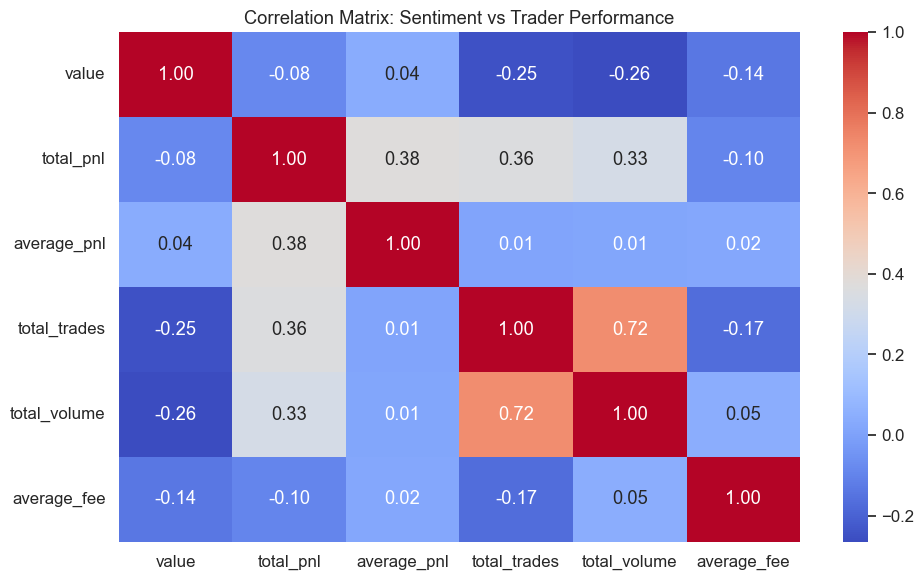

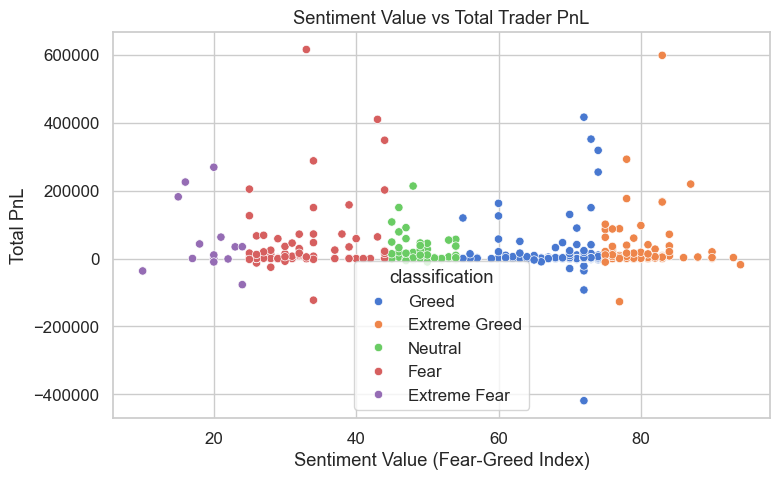

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Set plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Correlation matrix
correlation = merged_df[["value", "total_pnl", "average_pnl", "total_trades", "total_volume", "average_fee"]].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Sentiment vs Trader Performance")
plt.tight_layout()
plt.show()

# Scatter plot: Sentiment vs Total PnL
plt.figure(figsize=(8, 5))
sns.scatterplot(x="value", y="total_pnl", data=merged_df, hue="classification")
plt.title("Sentiment Value vs Total Trader PnL")
plt.xlabel("Sentiment Value (Fear-Greed Index)")
plt.ylabel("Total PnL")
plt.tight_layout()
plt.show()


In [4]:
# Group by sentiment classification
sentiment_analysis = merged_df.groupby("classification").agg(
    avg_total_pnl=("total_pnl", "mean"),
    avg_pnl_per_trade=("average_pnl", "mean"),
    avg_trade_count=("total_trades", "mean"),
    avg_volume=("total_volume", "mean"),
    avg_fee=("average_fee", "mean"),
    count=("classification", "count")
).sort_values(by="avg_total_pnl", ascending=False)

print(sentiment_analysis)


                avg_total_pnl  avg_pnl_per_trade  avg_trade_count  \
classification                                                      
Extreme Fear     52793.589178          38.433903      1528.571429   
Fear             36891.818040          31.276567       679.527473   
Extreme Greed    23817.292199          56.736108       350.807018   
Neutral          19297.323516          63.820699       562.477612   
Greed            11140.566181          39.412175       260.637306   

                  avg_volume   avg_fee  count  
classification                                 
Extreme Fear    8.177447e+06  0.938658     14  
Fear            5.311261e+06  2.211484     91  
Extreme Greed   1.091800e+06  1.044605    114  
Neutral         2.690180e+06  2.279741     67  
Greed           1.495246e+06  1.886188    193  


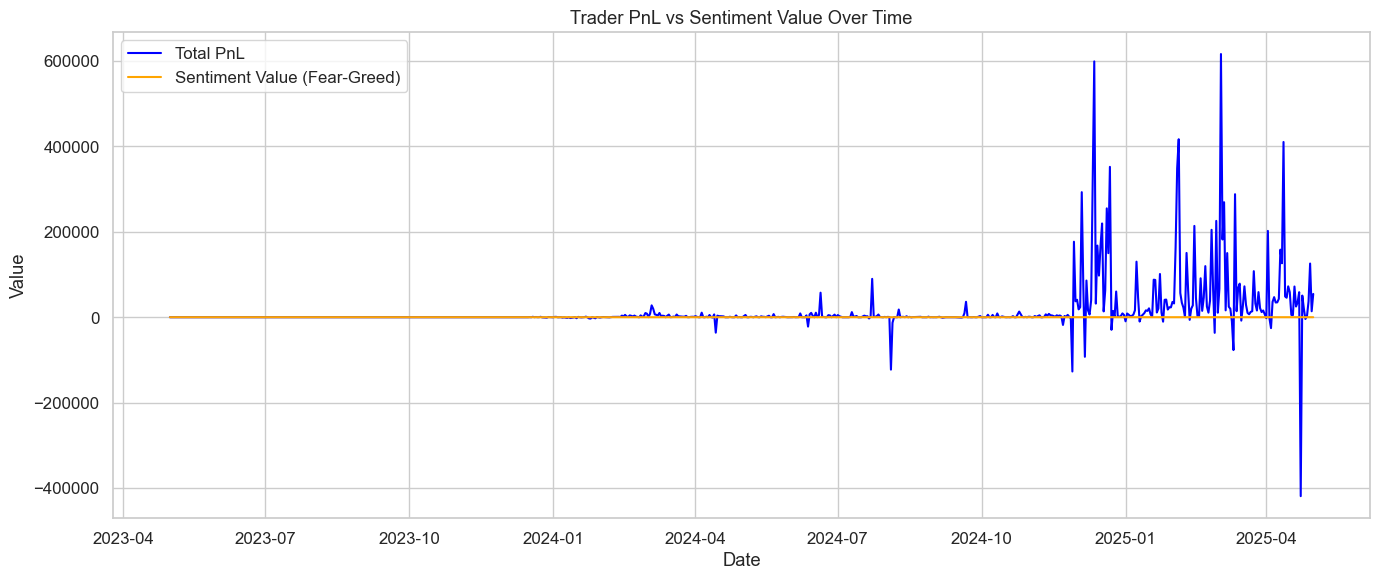

In [5]:
import matplotlib.pyplot as plt

# Sort by date
merged_df_sorted = merged_df.sort_values("date")

# Plot PnL and sentiment over time
plt.figure(figsize=(14, 6))
plt.plot(merged_df_sorted["date"], merged_df_sorted["total_pnl"], label="Total PnL", color="blue")
plt.plot(merged_df_sorted["date"], merged_df_sorted["value"], label="Sentiment Value (Fear-Greed)", color="orange")
plt.title("Trader PnL vs Sentiment Value Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


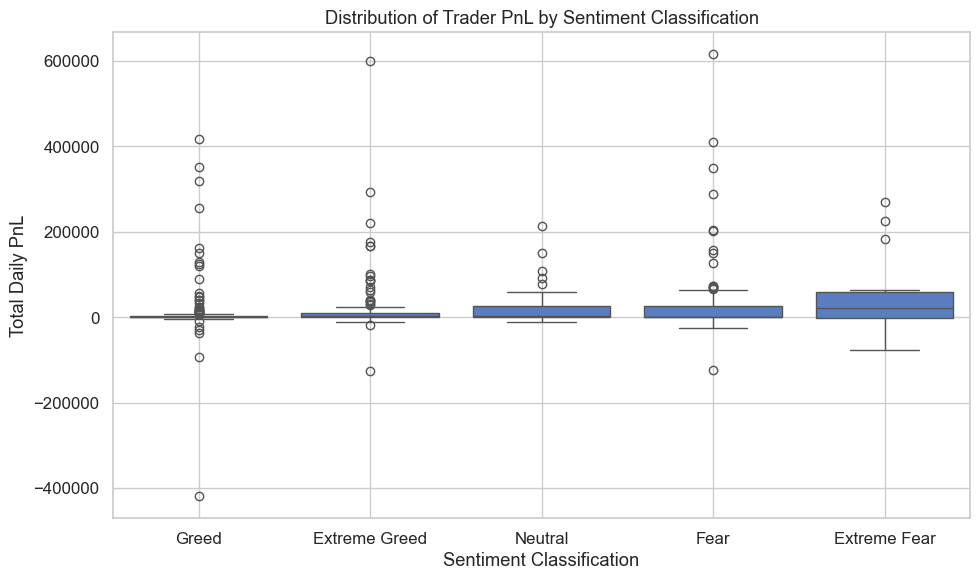

In [6]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x="classification", y="total_pnl", data=merged_df)
plt.title("Distribution of Trader PnL by Sentiment Classification")
plt.ylabel("Total Daily PnL")
plt.xlabel("Sentiment Classification")
plt.grid(True)
plt.tight_layout()
plt.show()
